<a href="https://colab.research.google.com/github/ljrn8/AB-resistance-in-ecoli/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3010 Machine Learning Assignment | 20757218 Joel Hoefs
Markdown cells are organised based on the criteria given in the assingment description for clarities sake.

## Setup

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

files = os.listdir('.')
assert files
for f in os.listdir('.'):
  print(f)

.config
y_pred
y_pred.csv
train.csv
sample_prediction.csv
test.csv
sample_data


In [200]:
sample_pred = pd.read_csv('sample_prediction.csv', index_col=False)
df = pd.read_csv('train.csv', index_col=False)      # train/validation
test_df = pd.read_csv('test.csv', index_col=False)  # test
len(df), len(test_df), len(sample_pred)

(10050, 3203, 3203)

In [201]:
df.columns

Index(['Unnamed: 0', 'Tank Failure Pressure (bar)', 'Liquid Ratio',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object')

In [202]:
for data in (df, test_df):
  data = data.drop('Unnamed: 0', axis=1)

## Preprocessing


In [203]:
print(f'na rows in train/valid: {len(df.dropna()) - len(df)}')
print(f'na rows in test: {len(test_df.dropna()) - len(test_df)}')

na rows in train/valid: -110
na rows in test: 0


In [204]:
# 110 is insignificant -> delete columns
df = df.dropna()

In [205]:
from scipy import stats

# filter outliers with the Z score method
def filter_outliers(df, cols, threshhold_z=2):
  df_c = df[cols]
  z = stats.zscore(df_c)
  non_outliers = abs(z) < threshhold_z

  print()
  for c in cols:
    print(f'outliers in [{c}] = {(~non_outliers[c]).sum()}')

  non_outliers_mask = non_outliers.all(axis=1)
  outliers = len(df_c) - len(df_c[non_outliers_mask])
  rate = outliers / len(df_c)
  print(f'num outliers: {outliers}\noutlier rate: {rate*100} %')

  return non_outliers_mask, df[non_outliers_mask]

drop_cols = ['Status', 'Unnamed: 0']
non_outliers_mask, filtered = filter_outliers(df, df.drop(drop_cols, axis=1).columns, threshhold_z=3.5)
non_outliers_mask_test, filtered_test = filter_outliers(test_df, test_df.drop(drop_cols, axis=1).columns, threshhold_z=3.5)


outliers in [Tank Failure Pressure (bar)] = 48
outliers in [Liquid Ratio] = 0
outliers in [Tank Width (m)] = 0
outliers in [Tank Length (m)] = 0
outliers in [Tank Height (m)] = 0
outliers in [BLEVE Height (m)] = 0
outliers in [Vapour Height (m)] = 0
outliers in [Vapour Temperature (K)] = 0
outliers in [Liquid Temperature (K)] = 0
outliers in [Obstacle Distance to BLEVE (m)] = 0
outliers in [Obstacle Width (m)] = 0
outliers in [Obstacle Height (m)] = 0
outliers in [Obstacle Thickness (m)] = 0
outliers in [Obstacle Angle] = 0
outliers in [Liquid Critical Pressure (bar)] = 0
outliers in [Liquid Boiling Temperature (K)] = 0
outliers in [Liquid Critical Temperature (K)] = 0
outliers in [Sensor ID] = 0
outliers in [Sensor Position Side] = 0
outliers in [Sensor Position x] = 0
outliers in [Sensor Position y] = 10
outliers in [Sensor Position z] = 0
outliers in [Target Pressure (bar)] = 142
num outliers: 200
outlier rate: 2.0120724346076457 %

outliers in [Tank Failure Pressure (bar)] = 0
out

In [206]:
df = df[non_outliers_mask]

In [207]:
# drop duplicates
df = df.drop_duplicates()

In [208]:
def filter_range(df, c, ub, lb):
  df_filtered = df[(df[c] >= lb) & (df[c] <= ub)]
  n_filtered =  len(df) - len(df_filtered)
  print(f'number of out-of-bounds [{c}] instances = {n_filtered}')
  return df_filtered

# rational metric upperbound for Kelvin/metres
UB = 1_000

filter_range_map = {
  'Tank Failure Pressure (bar)': (0, np.inf),
  'Liquid Ratio': (0, 1),
  'Tank Width (m)': (0, UB),
  'Tank Length (m)': (0, UB),
  'Tank Height (m)': (0, UB),
  'Vapour Height (m)': (0, UB),
  'BLEVE Height (m)': (0, UB),
  'Vapour Temperature (K)': (0, np.inf),
  'Liquid Temperature (K)': (0, UB),
  'Obstacle Distance to BLEVE (m)': (0, UB),
  'Obstacle Width (m)': (0, UB),
  'Obstacle Height (m)': (0, UB),
  'Obstacle Thickness (m)': (0, UB),
  'Obstacle Angle': (0, 30),
  'Sensor ID': (1, 27),
  'Sensor Position Side': (1, 5),
  'Sensor Position x': (-UB, UB),
  'Sensor Position y': (-UB, UB),
  'Sensor Position z': (-UB, UB),
  'Target Pressure (bar)': (0, np.inf),
}

df_interm = df.copy()
for column, (lb, ub) in filter_range_map.items():
  train_interm = filter_range(df_interm, column, ub, lb)

number of out-of-bounds [Tank Failure Pressure (bar)] instances = 0
number of out-of-bounds [Liquid Ratio] instances = 0
number of out-of-bounds [Tank Width (m)] instances = 0
number of out-of-bounds [Tank Length (m)] instances = 0
number of out-of-bounds [Tank Height (m)] instances = 0
number of out-of-bounds [Vapour Height (m)] instances = 0
number of out-of-bounds [BLEVE Height (m)] instances = 149
number of out-of-bounds [Vapour Temperature (K)] instances = 0
number of out-of-bounds [Liquid Temperature (K)] instances = 0
number of out-of-bounds [Obstacle Distance to BLEVE (m)] instances = 0
number of out-of-bounds [Obstacle Width (m)] instances = 0
number of out-of-bounds [Obstacle Height (m)] instances = 0
number of out-of-bounds [Obstacle Thickness (m)] instances = 0
number of out-of-bounds [Obstacle Angle] instances = 0
number of out-of-bounds [Sensor ID] instances = 0
number of out-of-bounds [Sensor Position Side] instances = 0
number of out-of-bounds [Sensor Position x] instan

(-0.05, 0.3)

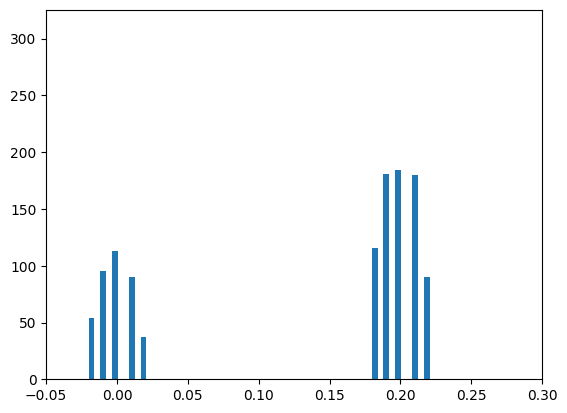

In [209]:
plt.hist(df['BLEVE Height (m)'], bins=500)
plt.xlim(-0.05, 0.3)

In [210]:
# some BLEVE Height (m) measurements were negative, so I'll just round them up
df['BLEVE Height (m)'] = df['BLEVE Height (m)'].map(lambda x: max(x, 0))

In [211]:
# ensure no incorrect categorical/ordinal entries:
for c in ('Status', 'Sensor Position Side', 'Sensor ID'):
  print(c + ' unique values: ')
  print(np.unique(df[c]))
  print()

Status unique values: 
['Saperheated' 'Subcoled' 'Subcool' 'Subcooled' 'Superheat' 'Superheated'
 'subcooled' 'superheated']

Sensor Position Side unique values: 
[1. 2. 3. 4. 5.]

Sensor ID unique values: 
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]



In [212]:
def status_map(name):
  if name in ['Saperheated', 'Superheat', 'Superheated', 'superheated']:
    return 'superheated'
  else:
    return 'subcooled'

df['Status'] = df['Status'].map(status_map)
np.unique(df['Status'])

array(['subcooled', 'superheated'], dtype=object)

In [213]:
# Feature Engineering:
for data in (df, test_df):

  # Dimension Ratio's
  data['Tank width/length Ratio'] = data['Tank Width (m)'] / data['Tank Length (m)']
  data['Tank width/height Ratio'] =  data['Tank Width (m)'] / data['Tank Height (m)']

  # precise distance to sensor
  sensor_offsets = np.sqrt(data['Sensor Position x']**2 + data['Sensor Position y']**2 + data['Sensor Position z']**2)
  data['Sensor-Obstacle Distance'] = data['Obstacle Distance to BLEVE (m)'] + sensor_offsets

In [214]:
# data type conversion
df['Status'] = df['Status'].map({"superheated": 0, "subcooled": 1})
test_df['Status'] = test_df['Status'].map({"Superheated": 0, "Subcooled": 1})

Feature Selection:

In [215]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.inspection import permutation_importance

X, y = df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2)

model = xgb.XGBRegressor().fit(X_train, y_train)
model.score(X_val, y_val)

r = permutation_importance(model, X_val, y_val,
                           n_repeats=50,
                           random_state=0)

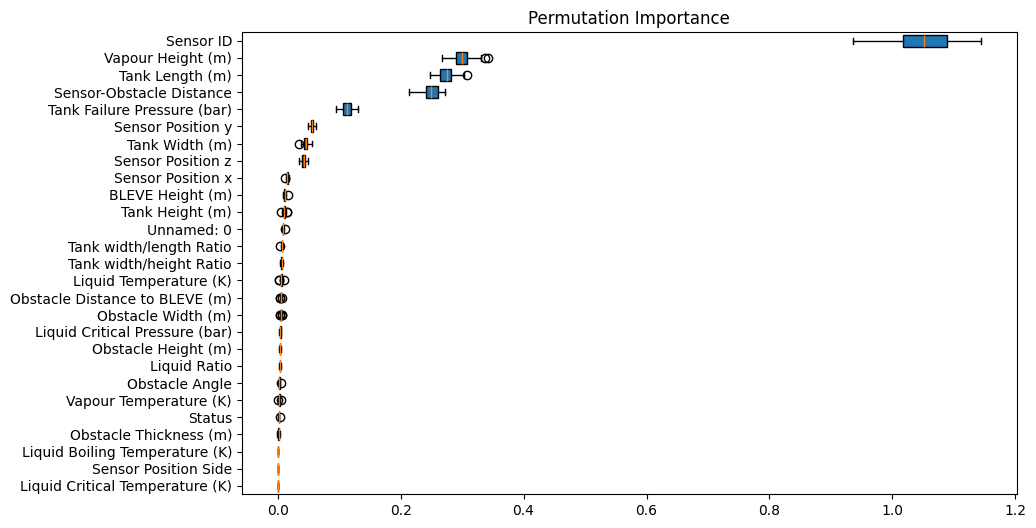

In [216]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'mean': [np.mean(r.importances[i]) for i in range(len(X.columns))],
    'dist': [r.importances[i] for i in range(len(X.columns))],
}).sort_values(by='mean')

plt.figure(figsize=(10, 6))

plt.boxplot(importance_df['dist'].values, vert=False, patch_artist=True, widths=0.7)

plt.yticks(range(1, len(importance_df) + 1), importance_df['Feature'])
plt.title('Permutation Importance')

plt.show()

In [217]:
# Remove bottom 3 features
def permutation_filter(df):
  return df.drop(
      ['Liquid Boiling Temperature (K)', 'Sensor Position Side', 'Liquid Critical Temperature (K)'],
      axis=1)

alternatively, I consider using PCA for 17 components

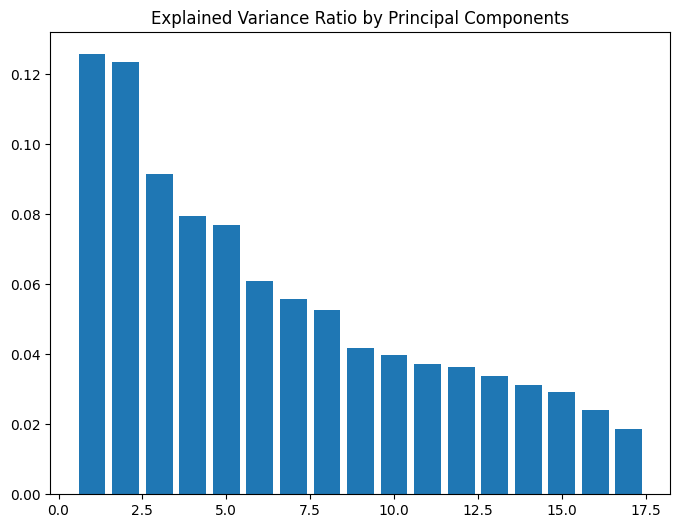

In [218]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X, y = df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
scaler = StandardScaler()

pca = PCA(n_components=17)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

## Model Developement

In [219]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, make_scorer


df = df.drop('Unnamed: 0', axis=1)
X, y =  df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']

# dataset based on perumation importance selection
X_pfi = permutation_filter(X)

# dataset based on PCA features
pca = PCA(n_components=17)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

#### Model Selection

In [47]:
scoring = {
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error)
}

scores = []

for X, dataset in (
    (X_pfi, 'Permutation importance'),
     (X_pca, 'PCA')):

  for (model, name) in ((xgb.XGBRegressor(), 'XGboost'),
                        (RandomForestRegressor(), 'RF'),
                        (SVR(), 'SVM'),
                        (LinearRegression(), 'LR')):

    scores_dict = cross_validate(model, X, y, scoring=scoring,
                        cv=5, return_train_score=True)

    scores.append((dataset + ' & ' + name, {
        'mean_test_R2': scores_dict['test_R2'].mean(),
        'mean_test_MAPE': scores_dict['test_MAPE'].mean(),
        'mean_train_MAPE': scores_dict['train_MAPE'].mean()
    }))

scores

[('Permutation importance & XGboost',
  {'mean_test_R2': np.float64(0.8223014252458276),
   'mean_test_MAPE': np.float64(0.35292802687806646),
   'mean_train_MAPE': np.float64(0.10161400477604868)}),
 ('Permutation importance & RF',
  {'mean_test_R2': np.float64(0.7694783441332191),
   'mean_test_MAPE': np.float64(0.3699704160735003),
   'mean_train_MAPE': np.float64(0.06852041458935484)}),
 ('Permutation importance & SVM',
  {'mean_test_R2': np.float64(0.15131522845361683),
   'mean_test_MAPE': np.float64(0.8353917396623964),
   'mean_train_MAPE': np.float64(0.8187362358495236)}),
 ('Permutation importance & LR',
  {'mean_test_R2': np.float64(0.5749597556983067),
   'mean_test_MAPE': np.float64(0.9847561982729234),
   'mean_train_MAPE': np.float64(0.9724892696430845)}),
 ('PCA & XGboost',
  {'mean_test_R2': np.float64(0.6240347335132085),
   'mean_test_MAPE': np.float64(0.7438024451896251),
   'mean_train_MAPE': np.float64(0.2081673546925152)}),
 ('PCA & RF',
  {'mean_test_R2': np.flo

* Permutation importance did better than PCA
* SVM & LR underperformed
* All methods overfit significantly

In [81]:
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn

class NN(nn.Module):
  def __init__(self, input_size, hidden_layers):
    super(NN, self).__init__()

    layers = []
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.ReLU())

    for i in range(1, len(hidden_layers)):
      layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
      layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_layers[-1], 1))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


def train_nn(
    epochs,
    input_size,
    hidden_layers,
    lr,
    eval_n=3,
    X=X, y=y
):

  ss = StandardScaler()
  X = ss.fit_transform(X)

  # conv to torch tensors
  X_torch = torch.tensor(X, dtype=torch.float32)
  y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

  X_train, X_valid, y_train, y_valid = train_test_split(
      X_torch, y_torch, test_size=0.2, random_state=0)

  model = NN(input_size, hidden_layers)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  R2, MAPE = [], []

  for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if epoch % (epochs // eval_n) == 0 or epoch == epochs - 1:
      print(f"Epoch {epoch}/{epochs}: loss {loss}")

      y_pred = model(X_valid)
      y_v, y_p = y_valid.detach().numpy(), y_pred.detach().numpy()
      mape =  mean_absolute_percentage_error(y_v, y_p)
      r2 = r2_score(y_v, y_p)
      print('MAPE: ', mape)
      print('R2: ', r2)

      R2.append(r2)
      MAPE.append(mape)


  return model, R2, MAPE

model, R2, MAPE = train_nn(epochs=500, input_size=26, hidden_layers=(64, 32), lr=0.005)

Epoch 0/500: loss 0.20210859179496765
MAPE:  1.253326416015625
R2:  -0.13363277912139893
Epoch 166/500: loss 0.004326269030570984
MAPE:  0.23496177792549133
R2:  0.9366157054901123
Epoch 332/500: loss 0.0023145542945712805
MAPE:  0.19329765439033508
R2:  0.9478635787963867
Epoch 498/500: loss 0.0017373093869537115
MAPE:  0.18394054472446442
R2:  0.9509464502334595
Epoch 499/500: loss 0.0017420329386368394
MAPE:  0.18230757117271423
R2:  0.9507788419723511


MLP performed best without tuning

#### Hyperparameter Tuning

##### XGBoost

In [50]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, make_scorer

model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [50, 70, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0.2, 0.3, 0.5],
}

scoring = {
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}

grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                scoring=scoring, cv=3, verbose=2, refit='MAPE', n_iter=500)

grid_search.fit(X_pfi, y)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END gamma=0.3, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END gamma=0.3, learning_rate=0.2, max_depth=7, min_child_weight=5, n_e

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'gamma': [0.2, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 5, 7],
                                        'n_estimators': [50, 70, 100],
                                        'subsample': [0.8, 0.9, 1.0]},
                   refit='MAPE',
                   scoring={'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False, response_method='predict'),
                            'R2': make_scorer(r2_score, response_method='predict')},
                   verbose=2)

In [56]:
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
scores_dict = cross_validate(best_model, X_pfi, y, scoring=scoring,
                        cv=5, return_train_score=True)

print('average test MAPE')
print(scores_dict['test_MAPE'].mean())

Best Hyperparameters:  {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2}
Best Score:  -0.3328082714570958
average test MAPE
-0.3236637992914192


##### Random Forest

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 30],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid, cv=4,
    n_jobs=-1, verbose=2,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)
)

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
{'max_depth': 30, 'min_samples_leaf': 4, 'n_estimators': 100}
RandomForestRegressor(max_depth=30, min_samples_leaf=4)
-0.37203561615746095


##### Nueral Network

In [65]:
model = train_nn(epochs=500, input_size=26, hidden_layers=(128, 64, 32), lr=0.005)

Epoch 0/500: loss 0.20214775204658508
MAPE:  0.7335477471351624
R2:  -0.2978501319885254
Epoch 166/500: loss 0.002607242437079549
MAPE:  0.19364212453365326
R2:  0.9456027150154114
Epoch 332/500: loss 0.0018161863554269075
MAPE:  0.17660051584243774
R2:  0.954575777053833
Epoch 498/500: loss 0.0010386693757027388
MAPE:  0.16466814279556274
R2:  0.9583035111427307
Epoch 499/500: loss 0.0010762885212898254
MAPE:  0.16003292798995972
R2:  0.9574868083000183


Observe where the model overfits manually

In [ ]:
model, R2, MAPE = train_nn(epochs=1_000, input_size=26, hidden_layers=(128, 64, 32), lr=0.005, eval_n=50)

Epoch 0/1000: loss 0.36527204513549805
MAPE:  0.7555569410324097
R2:  -0.23121201992034912
Epoch 20/1000: loss 0.12580958008766174
MAPE:  0.8732240796089172
R2:  0.4984637498855591
Epoch 40/1000: loss 0.03369741514325142
MAPE:  0.38808080554008484
R2:  0.8544047474861145
Epoch 60/1000: loss 0.013768845237791538
MAPE:  0.2947407364845276
R2:  0.9354177713394165
Epoch 80/1000: loss 0.01134139858186245
MAPE:  0.28236663341522217
R2:  0.9196077585220337
Epoch 100/1000: loss 0.006588400807231665
MAPE:  0.2689301073551178
R2:  0.9461027383804321
Epoch 120/1000: loss 0.005453568417578936
MAPE:  0.2552173137664795
R2:  0.9521623849868774
Epoch 140/1000: loss 0.004725311417132616
MAPE:  0.24067609012126923
R2:  0.9506646990776062
Epoch 160/1000: loss 0.004480396397411823
MAPE:  0.23019328713417053
R2:  0.9535375833511353
Epoch 180/1000: loss 0.004883816931396723
MAPE:  0.2231757640838623
R2:  0.9459589123725891
Epoch 200/1000: loss 0.003536246018484235
MAPE:  0.21648277342319489
R2:  0.95923620

Overfits at epoch ~600

In [83]:
from tqdm import tqdm

# instead of grid search or random search, Im only looking at a few logical hyper parameter configurations

results = []
for HP in (
    #   layers         LR    epochs
      ((128, 64, 32), 0.005, 600),      # medium
      ((64, 32), 0.01, 300),            # small
      ((64, 32, 16), 0.01, 300),        # small and long
      ((256, 128, 64, 32), 0.001, 800)  # big
):

  layers, lr, epochs = HP
  model, R2, MAPE = train_nn(epochs=epochs, input_size=26, hidden_layers=layers, lr=lr, eval_n=1)
  results.append((HP, (model, R2[-1], MAPE[-1])))

results

Epoch 0/600: loss 0.24641074240207672
MAPE:  0.6761947274208069
R2:  -0.36529338359832764
Epoch 599/600: loss 0.000996388727799058
MAPE:  0.1486375331878662
R2:  0.9597707986831665
Epoch 0/300: loss 0.46012142300605774
MAPE:  1.115708351135254
R2:  -0.955858588218689
Epoch 299/300: loss 0.0027464348822832108
MAPE:  0.18790140748023987
R2:  0.9466536641120911
Epoch 0/300: loss 0.2364860475063324
MAPE:  0.8318281769752502
R2:  -0.1578977108001709
Epoch 299/300: loss 0.0018396181985735893
MAPE:  0.1723833978176117
R2:  0.9557124376296997
Epoch 0/800: loss 0.25365447998046875
MAPE:  1.2352772951126099
R2:  -1.1368398666381836
Epoch 799/800: loss 0.0005864312406629324
MAPE:  0.15288792550563812
R2:  0.9605271816253662


[(((128, 64, 32), 0.005, 600),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=26, out_features=128, bias=True)
       (1): ReLU()
       (2): Linear(in_features=128, out_features=64, bias=True)
       (3): ReLU()
       (4): Linear(in_features=64, out_features=32, bias=True)
       (5): ReLU()
       (6): Linear(in_features=32, out_features=1, bias=True)
     )
   ),
   0.9597707986831665,
   0.1486375331878662)),
 (((64, 32), 0.01, 300),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=26, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=32, bias=True)
       (3): ReLU()
       (4): Linear(in_features=32, out_features=1, bias=True)
     )
   ),
   0.9466536641120911,
   0.18790140748023987)),
 (((64, 32, 16), 0.01, 300),
  (NN(
     (model): Sequential(
       (0): Linear(in_features=26, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=32, bias=True)
       (3): 

In [221]:
# best model was
model, r2, mape = results[-1][1]

### Final Evaluation

In [85]:
# results on validation data
print('r2 score:', r2)
print('MAPE score:', mape)

r2 score: 0.9605271816253662
MAPE score: 0.15288792550563812


In [222]:
# predict on test set
ss = StandardScaler()
X_test = ss.fit_transform(test_df.drop('Unnamed: 0', axis=1))
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).numpy()

y_pred

array([[0.08540966],
       [0.09698021],
       [0.11947605],
       ...,
       [0.78764296],
       [0.6332558 ],
       [0.63056785]], dtype=float32)

In [226]:
df = pd.DataFrame({
    'Target Pressure (bar)': y_pred.reshape(len(y_pred)),
    'ID': np.array(list(range(3203)))
})

In [227]:
df

,Target Pressure (bar),ID
0,0.085410,0
1,0.096980,1
2,0.119476,2
3,0.067028,3
4,0.089503,4
...,...,...
3198,0.757857,3198
3199,0.777093,3199
3200,0.787643,3200
3201,0.633256,3201


In [228]:
df.to_csv('y_pred.csv', index=False)